# ANNDL: 1st challenge


## ⚙️ Import Libraries
Import the libraries needed for the project and fix the seed for repeatability.

In [1]:
import numpy as np
import random

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

seed = 42
input_img_size = 96

np.random.seed(seed)
tf.random.set_seed(seed)

2024-11-13 16:46:56.049285: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-13 16:46:56.056080: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-13 16:46:56.065250: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-13 16:46:56.076277: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731512816.105288   52829 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731512816.11

## ⏳ Load the Data

The data are loaded from the filtered, pre-processed data. For more details, see '''Preprocessing.ipynb''' notebook.

In [1]:
filtered_dataset_path = '../Preprocessing/balanced_dataset.npz'
data = np.load(filtered_dataset_path)
X = data['images']
y = data['labels']

# Define a mapping of labels to their corresponding digit names
labels = {0:'Basophil', 1:'Eosinophil', 2:'Erythroblast', 3:'Immature granulocytes', 4:'Lymphocyte', 5:'Monocyte', 6:'Neutrophil', 7:'Platelet'}

# Save unique labels
unique_labels = list(labels.values())

# Show the shape of the dataset
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

NameError: name 'np' is not defined

##  🦠 Process the Data


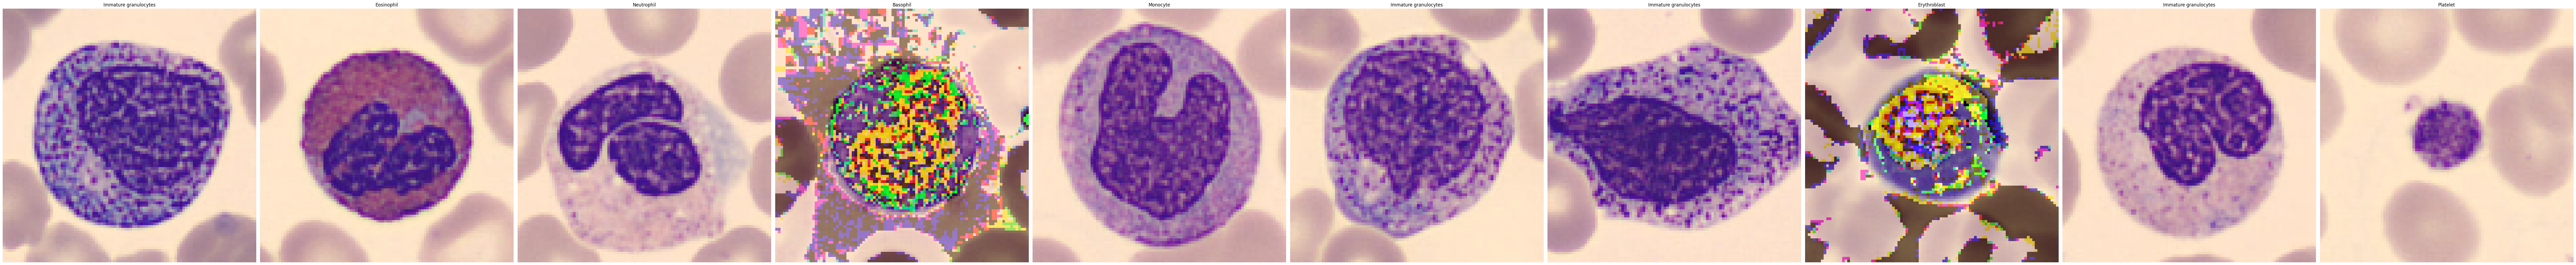

In [6]:
# Display a sample of images from the training-validation dataset
num_img = 10
random_indices = random.sample(range(len(X)), num_img)

fig, axes = plt.subplots(1, num_img, figsize=(input_img_size, input_img_size))

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(X[idx]), vmin=0., vmax=1.)
    ax.set_title(labels[y[idx]])
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

In [7]:
# Inspect the target
print('Counting occurrences of target classes:')
print(pd.DataFrame(y, columns=['digit'])['digit'].value_counts())

Counting occurrences of target classes:
digit
7    2330
3    2330
6    2330
2    2330
1    2330
5    2330
0    2330
4    2330
Name: count, dtype: int64


In [ ]:
# Normalize the data to the range [0, 1] and encode output labels
X = (X / 255).astype('float32')
y = tfk.utils.to_categorical(y, num_classes=len(unique_labels))

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)
print(f'Training data shape: {X_train.shape}, Validation data shape: {X_val.shape}')
print(f'Training labels shape: {y_train.shape}, Validation labels shape: {y_val.shape}')

## 🔆 Agumenting the training and validation set
We use AutoContrast and RandomSaturation from the keras library for the training set. It enhances contrast adaptively and may help in highlighting subtle differences between cell types without altering structure. 
We added the agumented images to the training set & we applied some rotation, zoom and shift.

We use RandAugment for the validation set. 

In [6]:
# Import keras
import keras_cv as kcv

c:\Users\motti\Documents\ANNDL\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


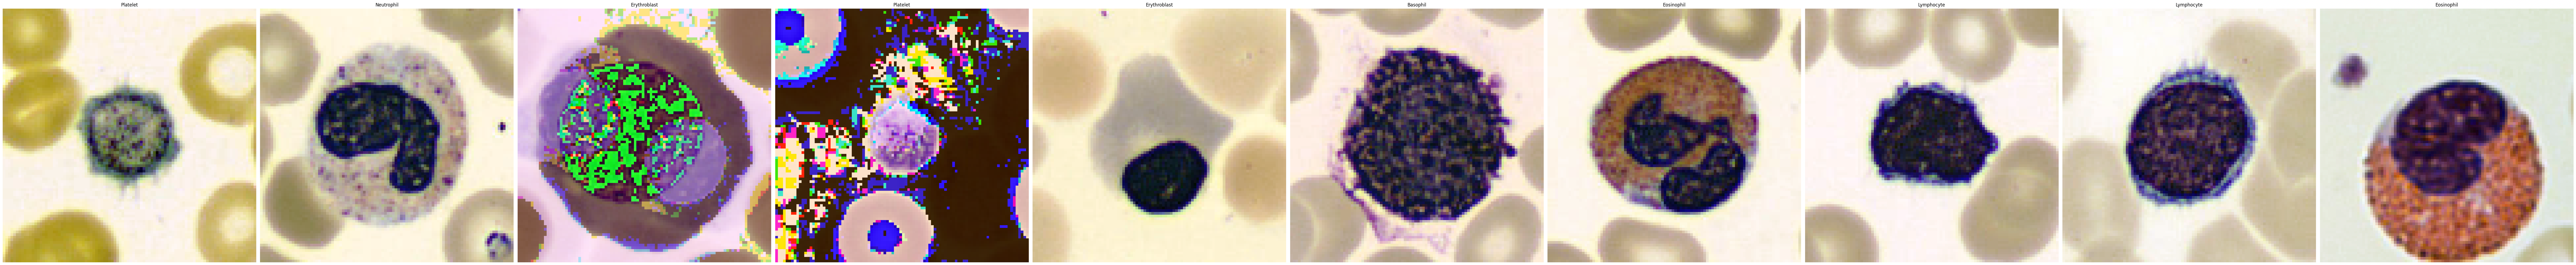

In [7]:
# Implement AutoContrast
value_range = [0, 1]
autocontrast = kcv.layers.AutoContrast(value_range)
contrast_result = autocontrast({'images': X_train, 'labels': y_train})

# Show some images
num_img = 10
random_indices = random.sample(range(len(contrast_result["images"])), num_img)
fig, axes = plt.subplots(1, num_img, figsize=(input_img_size, input_img_size))

for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(contrast_result["images"][idx]), vmin=0., vmax=1.)
    # Get the index of the maximum value (representing the predicted class)
    label_index = np.argmax(contrast_result["labels"][idx])
    ax.set_title(labels[label_index])
    ax.axis('off')

plt.tight_layout()
plt.show()

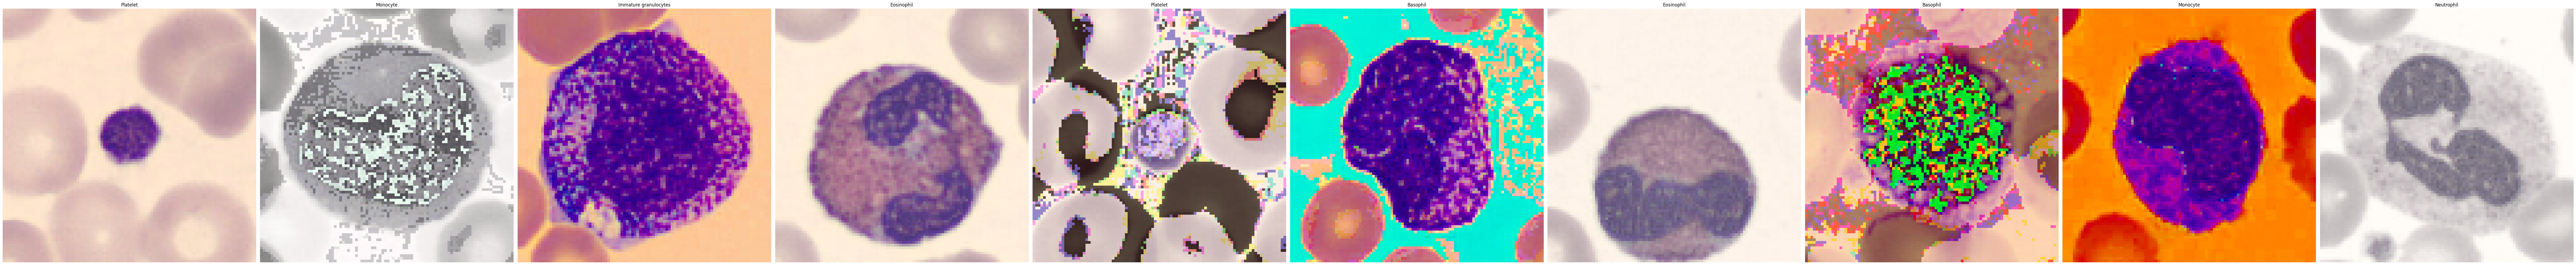

In [8]:
# Implement RandomSaturation
factor = [0, 1]
randomsaturation = kcv.layers.RandomSaturation(factor, seed=seed)
saturation_result = randomsaturation({'images': X_train, 'labels': y_train})

# Show some images
num_img = 10
random_indices = random.sample(range(len(saturation_result["images"])), num_img)
fig, axes = plt.subplots(1, num_img, figsize=(input_img_size, input_img_size))

for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(saturation_result["images"][idx]), vmin=0., vmax=1.)
    # Get the index of the maximum value (representing the predicted class)
    label_index = np.argmax(saturation_result["labels"][idx])
    ax.set_title(labels[label_index])
    ax.axis('off')

plt.tight_layout()
plt.show()

In [9]:
# Add the result of the augmentatation to the original training set
X_train = np.concatenate((X_train, contrast_result["images"]), axis=0)
y_train = np.concatenate((y_train, contrast_result["labels"]), axis=0)
X_train = np.concatenate((X_train, saturation_result["images"]), axis=0)
y_train = np.concatenate((y_train, saturation_result["labels"]), axis=0)

# Inspect the target
print('Counting occurrences of target classes:')
y_train_indices = np.argmax(y_train, axis=1) #
print(pd.DataFrame(y_train_indices, columns=['digit'])['digit'].value_counts())

Counting occurrences of target classes:
digit
0    4893
1    4893
3    4893
7    4893
5    4893
4    4893
6    4893
2    4893
Name: count, dtype: int64


val_agumented shape: (5592, 96, 96, 3)
y_val shape: (5592, 8)
Augmented X_val shape: (11184, 96, 96, 3)
Augmented y_val shape: (11184, 8)


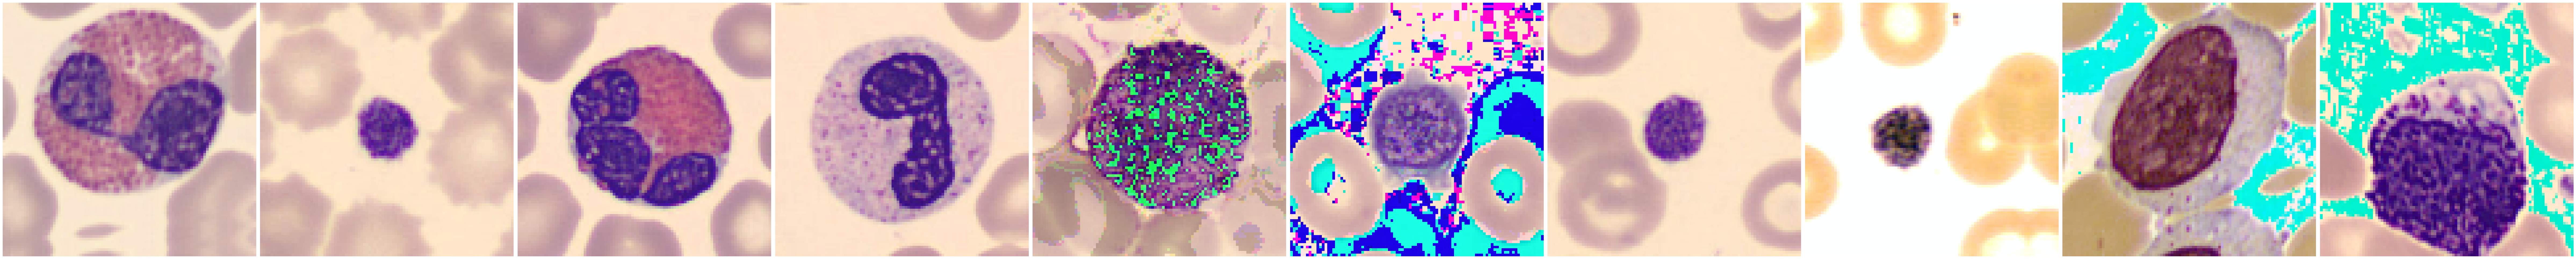

In [10]:
# Augmenting validation set
randaugment = kcv.layers.RandAugment(value_range=(0,1), augmentations_per_image=3, magnitude=0.3)
val_augmented = randaugment(X_val)
print("val_agumented shape:", val_augmented.shape)
print("y_val shape:", y_val.shape)
X_val = np.concatenate((X_val, val_augmented), axis=0)
y_val = np.concatenate((y_val, y_val), axis=0)
print("Augmented X_val shape:", X_val.shape)
print("Augmented y_val shape:", y_val.shape)

# Show some images
num_img = 10
random_indices = random.sample(range(len(X_val)), num_img)
fig, axes = plt.subplots(1, num_img, figsize=(input_img_size, input_img_size))

for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(X_val[idx]), vmin=0., vmax=1.)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,         # Equivalent to RandomRotation
    width_shift_range=0.2,     # Equivalent to RandomTranslation on x-axis
    height_shift_range=0.2,    # Equivalent to RandomTranslation on y-axis
    zoom_range=0.2,            # Equivalent to RandomZoom
    horizontal_flip=True,      # Equivalent to RandomFlip (horizontal)
    vertical_flip=True         # Equivalent to RandomFlip (vertical)
)

train_generator = datagen.flow(X_train, y_train)

## Transfer Learning

In [12]:
# Initialise densenet model with pretrained weights, for transfer learning
dense = tfk.applications.densenet.DenseNet121(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet',
    pooling=None,
    classifier_activation='softmax'
)


# Display a summary of the model architecture
# dense.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(dense, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [13]:
# Freeze all layers in DenseNet to use it solely as a feature extractor
dense.trainable = False

# Define input layer with shape matching the input images
inputs = tfk.Input(shape=(96, 96, 3), name='input_layer')

# Pass inputs through the feature extractor
x = dense(inputs)

# Add a Global Average Pooling layer to flatten the spatial dimensions
x = tfkl.GlobalAveragePooling2D(name='global_avg_pool')(x)

# Add a dropout layer for regularisation
x = tfkl.Dropout(0.3, name='dropout')(x)

# Add final Dense layer for classification with softmax activation
outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='dense')(x)

# Define the complete model linking input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with categorical cross-entropy loss and Adam optimiser
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Display a summary of the model architecture
# tl_model.summary(expand_nested=True)

In [ ]:
# Train the model
tl_history = tl_model.fit(
    train_generator,
    batch_size=16,
    epochs=5,
    validation_data=(X_val, y_val),
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(tl_history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
model_filename = 'TL_dense_' + str(final_val_accuracy) + '.keras'
tl_model.save(model_filename)

# Free memory by deleting the model instance
del tl_model

c:\Users\motti\Documents\ANNDL\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 453s 362ms/step - accuracy: 0.5331 - loss: 1.4404 - val_accuracy: 0.6820 - val_loss: 1.0403
Epoch 2/5
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 515s 421ms/step - accuracy: 0.7175 - loss: 0.8198 - val_accuracy: 0.6583 - val_loss: 1.1232
Epoch 3/5
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 444s 362ms/step - accuracy: 0.7259 - loss: 0.7917 - val_accuracy: 0.7169 - val_loss: 0.9785
Epoch 4/5
 791/1224 ━━━━━━━━━━━━━━━━━━━━ 2:18 321ms/step - accuracy: 0.7184 - loss: 0.8011

## 🛠️ Train and Save the Model

In [ ]:
# Hyperparameters
epochs = 50
batch_size = 16
learning_rate = 0.001

# Retrieve input and output shape
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1]

In [ ]:
def build_model (
  input_shape = input_shape,
  output_shape = output_shape,
  learning_rate = learning_rate,
  dropout_rate = 0.5,
  augmentation = None,
  flatten = True,
  seed = seed):

  tf.random.set_seed(seed)
  num_filters = 16
  default_kernel_size = 3

  # Input layer
  inputs = tfkl.Input(shape=input_shape, name='Input')

  # Apply augmentation layers, if specified, and create the first convolutional layer
  if augmentation is None:
    x = tfkl.Conv2D(filters=num_filters, kernel_size=default_kernel_size, padding='same', activation='relu', name='Conv2D_1')(inputs)
  else:
    x = augmentation(inputs)
    x = tfkl.Conv2D(filters=num_filters, kernel_size=default_kernel_size, padding='same', activation='relu', name='Conv2D_1')(x)
  x = tfkl.MaxPooling2D(pool_size=2, name='MaxPooling2D_1')(x)

  x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='Conv2D_2')(x)
  x = tfkl.ReLU(name='relu2')(x)
  x = tfkl.MaxPooling2D(name='mp2')(x)

  x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='Conv2D_3')(x)
  x = tfkl.ReLU(name='relu3')(x)
  x = tfkl.MaxPooling2D(name='mp3')(x)

  x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', name='Conv2D_4')(x)
  x = tfkl.ReLU(name='relu4')(x)
  x = tfkl.MaxPooling2D(name='mp4')(x)

  # Flatten layer
  if flatten == True:
    x = tfkl.Flatten(name='Flatten')(x)
  else:
    x = tfkl.GlobalAveragePooling2D(name='GlobalAveragePooling2D')(x)

  # Fully connected layers
  x = tfkl.Dense(units=128, activation='relu', name='Dense_1')(x)
  x = tfkl.Dropout(rate=dropout_rate, name='Dropout1')(x)

  x = tfkl.Dense(units=64, activation='relu', name='Dense_2')(x)
  x = tfkl.Dropout(rate=dropout_rate, name='Dropout2')(x)

  # Output layer
  x = tfkl.Dense(units=output_shape, name='Output')(x)
  outputs = tfkl.Activation('softmax', name='Activation_Output')(x)

  # Create the model
  model = tfk.Model(inputs=inputs, outputs=outputs, name='CNN_Model')

  # Compile the model with ADAM optimizer
  loss = tfk.losses.CategoricalCrossentropy()
  optimizer = tfk.optimizers.Adam(learning_rate)
  metrics = ['accuracy']
  model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

  return model

In [ ]:
# Early stopping callback
patience = 20

early_stopping = tfk.callbacks.EarlyStopping (
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

callbacks = [early_stopping]

In [ ]:
# Build the model with specified input and output shapes
model = build_model(flatten=False)

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [ ]:
history = model.fit (
    train_generator,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = callbacks
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'weights.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

In [ ]:
# Load the saved model
model = tfk.models.load_model(model_filename)

# Compute the confusion matrix
predictions = model.predict(X_val)
pred_classes = np.argmax(predictions, axis=-1)
true_classes = np.argmax(y_val, axis=-1)
cm = confusion_matrix(true_classes, pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, annot=True, fmt='', xticklabels=unique_labels, yticklabels=unique_labels, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
# Plot the loss and accuracy metrics
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training set', alpha=.3, color='green', linestyle='--')
plt.plot(history['val_loss'], label='Validation set', alpha=.8, color='blue')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training set', alpha=.3, color='green', linestyle='--')
plt.plot(history['val_accuracy'], label='Validation set', alpha=.8, color='blue')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

## 📊 Prepare Your Submission

To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:

```python
# file: model.py
class Model:
    def __init__(self):
        """Initialize the internal state of the model."""

    def predict(self, X):
        """Return a numpy array with the labels corresponding to the input X."""
```

The next cell shows an example implementation of the `model.py` file, which includes loading model weights from the `weights.keras` file and conducting predictions on provided input data. The `.zip` file is created and downloaded in the last notebook cell.

❗ Feel free to modify the method implementations to better fit your specific requirements, but please ensure that the class name and method interfaces remain unchanged.

In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        X = X / 255.0
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds